In [61]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [62]:
df = pd.read_csv('APPL_DATA.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.100039
1,1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.094820
2,1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.087861
3,1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090035
4,1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.092646


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10564 entries, 0 to 10563
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10564 non-null  object 
 1   High       10564 non-null  float64
 2   Low        10564 non-null  float64
 3   Open       10564 non-null  float64
 4   Close      10564 non-null  float64
 5   Volume     10564 non-null  float64
 6   Adj Close  10564 non-null  float64
dtypes: float64(6), object(1)
memory usage: 577.8+ KB


In [64]:
df.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'Unit Terjual')

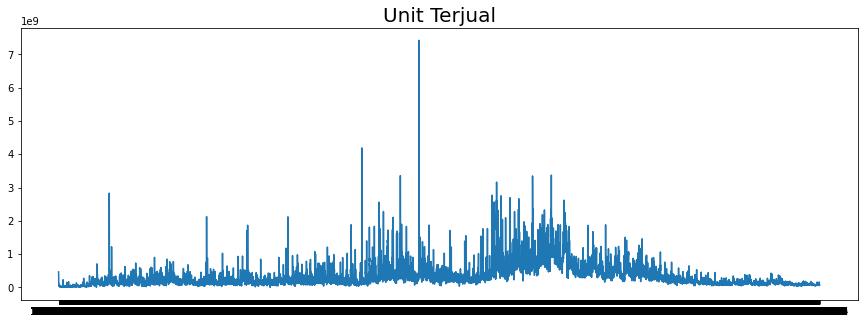

In [65]:
dates = df['Date'].values
volume = df['Volume'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, volume)
plt.title('Unit Terjual', fontsize=20)

In [66]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [67]:
volume = volume.reshape(-1, 1)
volume

array([[4.6903360e+08],
       [1.7588480e+08],
       [1.0572800e+08],
       ...,
       [8.0379300e+07],
       [9.3436100e+07],
       [6.2275031e+07]])

In [68]:
scaler = MinMaxScaler()
volume = scaler.fit_transform(volume)

In [75]:
x_train, x_val, y_train, y_val = train_test_split(volume, dates, test_size=0.2, shuffle=False)

# size x_train dan x_val
print(len(x_train), len(x_val))

8451 2113


In [70]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [87]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set  = windowed_dataset(x_val, window_size=60, batch_size=32, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True, input_shape = [None, 1]),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [72]:
nilai_x = (volume.max() - volume.min()) * (10 / 100)

In [73]:
class callbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < nilai_x):
      print('MAE < 10% skala data')
      self.model.stop_training = True

callbacks = callbacks()

In [88]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(), 
    optimizer = optimizer,
    metrics=['mae']
)

In [93]:
history = model.fit(
    train_set,
    epochs=100,
    validation_data=val_set,
    verbose=2,
    callbacks=[callbacks],
)

Epoch 1/100
MAE < 10% skala data
84/84 - 33s - loss: 0.0018 - mae: 0.0374 - val_loss: 4.4124e-05 - val_mae: 0.0068 - 33s/epoch - 395ms/step
